# SAE Training Example

## Adding src to sys.path for imports

In [ ]:
import sys
import os
#os.chdir("AstroBio")
sys.path.append("./src")



## Imports

In [3]:
import torch
import scanpy as sc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

# local
from src.models import SparseAutoencoder
from src.dataset import EmbeddingDataset


## Load scanpy object

In [5]:
adata = sc.read_h5ad("./data/external/adata_sample.h5ad")
embeddings_data = adata.obsm["geneformer"]

## Create Datasets

In [10]:
dset = EmbeddingDataset(embeddings_data)
train_dataset, test_dataset = random_split(dset, [0.8, 0.2])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training the Model

Training: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s, Train Loss=0.0033, Test Loss=0.0047, Train Recon=0.0030, Test Recon=0.0044]


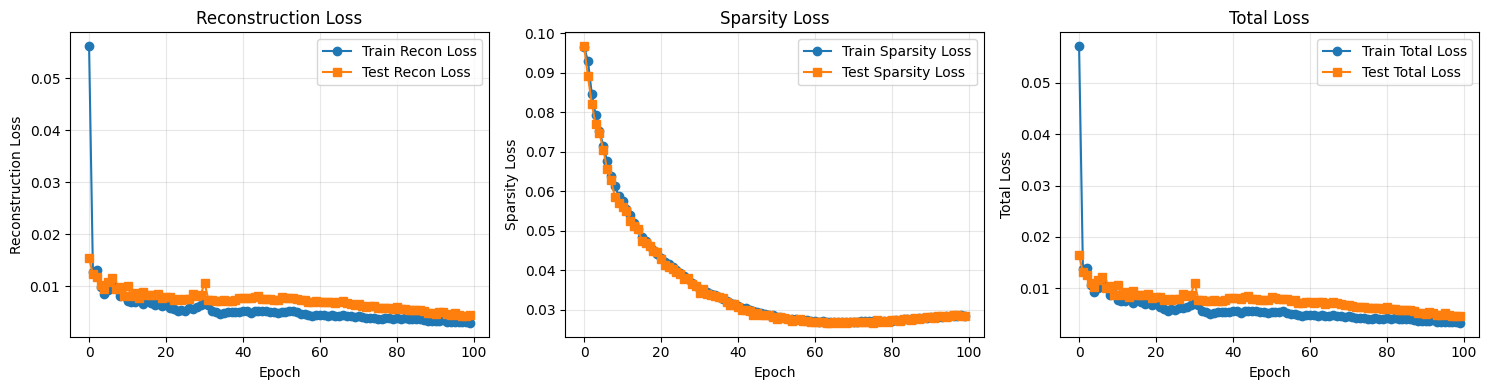

{'train_recon_loss': [0.05616540330648422,
  0.012833377435803414,
  0.013137572593986988,
  0.00985770694166422,
  0.008541468113660812,
  0.009279036018997431,
  0.010727268312126398,
  0.009410259008407593,
  0.008149594116955995,
  0.008215720091015101,
  0.007199843812733889,
  0.007020474039018154,
  0.00695609262958169,
  0.00748048759624362,
  0.006686666291207075,
  0.007365664791315794,
  0.006907046981155873,
  0.006508027587085962,
  0.007103641726076603,
  0.006254331704229116,
  0.006455944448709488,
  0.0059002812765538695,
  0.005629431638866663,
  0.00525832487642765,
  0.005533400639891625,
  0.0053479187749326225,
  0.00578441908583045,
  0.00574960769340396,
  0.006032218437641859,
  0.006396811861544847,
  0.006952500212937593,
  0.006503935039043426,
  0.005338945467025041,
  0.005122287966310978,
  0.004763935048133135,
  0.004879803918302059,
  0.004995243482291699,
  0.005026484709233046,
  0.005013163194060325,
  0.005086425974965095,
  0.0052486865818500514,


In [12]:
model = SparseAutoencoder(input_dim=512,hidden_dim=1028, expanded_ratio=4.0)
model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=100,
    lr=1e-3,
    sparsity_weight=1e-2,
    
)

In [ ]:
n_epoches = 1

optimizer = Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.train()

for i_epoch in range(n_epoches):
    for i_step, d in enumerate(train_loader):
        d = d.to(device)
        optimizer.zero_grad()
        recon, embed = model(d)
        recon_loss, sparsity_loss, total_loss = model.get_total_loss(d, recon, embed, sparsity_weight=1e-2)
        total_loss.backward()
        optimizer.step()

        if i_step % 100:
            model.eval()
            for test_d in test_loader:
                test_d = test_d.to(device)
                with torch.no_grad():
                    test_recon, test_embed = model(test_d)  
                    test_recon_loss, test_sparsity_loss, test_total_loss = model.get_total_loss(test_d, test_recon, test_embed, sparsity_weight=1e-2)
                    print(f"epoches {i_epoch}, steps {i_step}, loss (recon_loss): {test_recon_loss.item()}, loss (sparsity): {test_sparsity_loss.item()}, loss (total): {test_total_loss.item()}")
            model.train()

In [ ]:
import matplotlib.pyplot as plt
def train_model(model, train_loader, test_loader, n_epochs=1, lr=1e-3, sparsity_weight=1e-2, 
                device=None, plot_losses=True):
    """
    Train the sparse autoencoder model and track training/test losses per epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to train.
    train_loader : torch.utils.data.DataLoader
        Training data loader.
    test_loader : torch.utils.data.DataLoader
        Test data loader.
    n_epochs : int, default=1
        Number of training epochs.
    lr : float, default=1e-3
        Learning rate for optimizer.
    sparsity_weight : float, default=1e-2
        Weight for sparsity loss.
    device : torch.device, optional
        Device to train on. If None, will use CUDA if available, else CPU.
    plot_losses : bool, default=True
        Plot losses per epoch.
    
    Returns
    -------
    dict
        Dictionary containing lists of epoch-level mean losses:
        - train_recon_loss: Mean training reconstruction losses per epoch
        - train_sparsity_loss: Mean training sparsity losses per epoch
        - train_total_loss: Mean training total losses per epoch
        - test_recon_loss: Mean test reconstruction losses per epoch
        - test_sparsity_loss: Mean test sparsity losses per epoch
        - test_total_loss: Mean test total losses per epoch
        - epochs: Epoch numbers
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    optimizer = Adam(model.parameters(), lr=lr)
    model = model.to(device)
    
    # Initialize epoch-level loss tracking lists
    train_recon_losses = []
    train_sparsity_losses = []
    train_total_losses = []
    test_recon_losses = []
    test_sparsity_losses = []
    test_total_losses = []
    epochs = []
    
    model.train()
    for i_epoch in range(n_epochs):
        # Track losses for this epoch
        epoch_train_recon = []
        epoch_train_sparsity = []
        epoch_train_total = []
        
        # Training phase
        for i_step, d in enumerate(train_loader):
            d = d.to(device)
            optimizer.zero_grad()
            recon, embed = model(d)
            recon_loss, sparsity_loss, total_loss = model.get_total_loss(
                d, recon, embed, sparsity_weight=sparsity_weight
            )
            total_loss.backward()
            optimizer.step()
            
            # Collect training losses for this epoch
            epoch_train_recon.append(recon_loss.item())
            epoch_train_sparsity.append(sparsity_loss.item())
            epoch_train_total.append(total_loss.item())
            
        # Compute mean training losses for this epoch
        avg_train_recon = sum(epoch_train_recon) / len(epoch_train_recon)
        avg_train_sparsity = sum(epoch_train_sparsity) / len(epoch_train_sparsity)
        avg_train_total = sum(epoch_train_total) / len(epoch_train_total)
        
        train_recon_losses.append(avg_train_recon)
        train_sparsity_losses.append(avg_train_sparsity)
        train_total_losses.append(avg_train_total)
        
        # Evaluate on test set after each epoch
        model.eval()
        test_recon_loss_epoch = []
        test_sparsity_loss_epoch = []
        test_total_loss_epoch = []
        
        with torch.no_grad():
            for test_d in test_loader:
                test_d = test_d.to(device)
                test_recon, test_embed = model(test_d)
                test_recon_loss, test_sparsity_loss, test_total_loss = model.get_total_loss(
                    test_d, test_recon, test_embed, sparsity_weight=sparsity_weight
                )
                test_recon_loss_epoch.append(test_recon_loss.item())
                test_sparsity_loss_epoch.append(test_sparsity_loss.item())
                test_total_loss_epoch.append(test_total_loss.item())
        
        # Average test losses for this epoch
        avg_test_recon = sum(test_recon_loss_epoch) / len(test_recon_loss_epoch)
        avg_test_sparsity = sum(test_sparsity_loss_epoch) / len(test_sparsity_loss_epoch)
        avg_test_total = sum(test_total_loss_epoch) / len(test_total_loss_epoch)
        
        test_recon_losses.append(avg_test_recon)
        test_sparsity_losses.append(avg_test_sparsity)
        test_total_losses.append(avg_test_total)
        epochs.append(i_epoch)
        
        print(f"\nEpoch {i_epoch} Summary:")
        print(f"  Train - Total: {avg_train_total:.4f}, Recon: {avg_train_recon:.4f}, Sparsity: {avg_train_sparsity:.4f}")
        print(f"  Test  - Total: {avg_test_total:.4f}, Recon: {avg_test_recon:.4f}, Sparsity: {avg_test_sparsity:.4f}\n")
        
        model.train()
    
    # Plot losses per epoch
    if plot_losses:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Plot reconstruction loss
        axes[0].plot(epochs, train_recon_losses, label='Train Recon Loss', marker='o', markersize=6)
        axes[0].plot(epochs, test_recon_losses, label='Test Recon Loss', marker='s', markersize=6)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Reconstruction Loss')
        axes[0].set_title('Reconstruction Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot sparsity loss
        axes[1].plot(epochs, train_sparsity_losses, label='Train Sparsity Loss', marker='o', markersize=6)
        axes[1].plot(epochs, test_sparsity_losses, label='Test Sparsity Loss', marker='s', markersize=6)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Sparsity Loss')
        axes[1].set_title('Sparsity Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot total loss
        axes[2].plot(epochs, train_total_losses, label='Train Total Loss', marker='o', markersize=6)
        axes[2].plot(epochs, test_total_losses, label='Test Total Loss', marker='s', markersize=6)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Total Loss')
        axes[2].set_title('Total Loss')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'train_recon_loss': train_recon_losses,
        'train_sparsity_loss': train_sparsity_losses,
        'train_total_loss': train_total_losses,
        'test_recon_loss': test_recon_losses,
        'test_sparsity_loss': test_sparsity_losses,
        'test_total_loss': test_total_losses,
        'epochs': epochs
    }

In [12]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 571 bytes | 571.00 KiB/s, done.
From https://github.com/ranaabarghout/AstroBio
   f337fe8..39b1910  main       -> origin/main
Updating f337fe8..39b1910
Fast-forward
 src/models.py | 14 ++++++++++----
 1 file changed, 10 insertions(+), 4 deletions(-)
